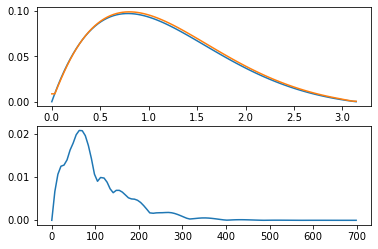

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import tkinter as tk
import tkinter.ttk as ttk

a = 1
b = 1
c = -3
d = 2

l = np.pi
K = 700
N = 100



# Граничные условия
phi0 = lambda t: 0
phil = lambda t: 0

# Начальные условия
gamma0 = lambda x: 0
gamma1 = lambda x: 2*np.exp(-x)*np.sin(x)

f = lambda x, t: 0

# Аналитическое решение
fResult = lambda x, t: np.exp(-t-x) * np.sin(x)*np.sin(2*t)

h = l / N
sigma = 0.4
taw = np.sqrt(sigma * h ** 2 / a)
mu = b * taw**2 / 2 / h
U = []

def gridFun(xCond, tCond):
    xlCond,xrCond = xCond
    tlCond, trCond = tCond
    return np.zeros((xrCond, trCond))


def plotSlice(f, X, t):
    plt.subplot(2, 1, 1)
    plt.plot(X, f(X, t))
    plt.grid


def Error(U, fResult, count):
    X = np.linspace(0, l, N)
    Y = list(map(int, np.linspace(0, U.shape[0] - 1, count)))
    plt.subplot(2, 1, 2)
    plt.plot(Y, list(map(lambda tt: np.max(np.abs(U[tt] - fResult(X, taw*tt))), Y)))

def showPostProcess(t):
    X = np.linspace(0, l, N)
    plotSlice(fResult, X, taw * t)
    plt.subplot(2, 1, 1)
    plt.plot(X, U[t])

def D(f):
    dx = 0.000001
    return lambda x: (f(x + dx)-f(x)) / dx


# Явная конечно-разностная схема
def explicitMethod(iCondition, bCondition, f, order=(1, 1)):
    def explicitWithFirstDegreeB():
        # 1 порядка
        for k in range(1, K - 1):
            U[k + 1][0] = (- alpha0 / h * U[k + 1][1] + phi0(taw * (k + 1))) / (betta0 - alpha0 / h)
            U[k + 1][N - 1] = (alphal / h * U[k + 1][N - 2] + phil(taw * (k + 1))) / (bettal + alphal / h)
        pass

    def explicitWithSecondDegreeB():
        # 2 порядка
        for k in range(1, K - 1):
            U[k + 1][0] = (- alpha0 / h / 2 * (4 * U[k + 1][1] - U[k + 1][2]) + phi0(taw * (k + 1))) / (
            betta0 - 3 * alpha0 / h / 2)
            U[k + 1][N - 1] = (- alphal / h / 2 * (U[k + 1][N - 3] - 4 * U[k + 1][N - 2]) + phil(taw * (k + 1))) / (
            bettal + 3 * alphal / h / 2)

    def explicitWithThirdDegreeB():
        b0 = 2*a/h + h/taw**2 - h*c - betta0/alpha0*(2*a - b*h) + d*h/2/taw
        c0 = -2*a/h
        bN = 2*a/h + h/taw**2 - h*c + bettal/alphal*(2*a + b*h) + d*h/2/taw
        aN = -2*a/h
        for k in range(1, K - 1):
            d0 = 2*h/taw**2 * U[k][0] + (- h/taw**2 + d*h/2/taw)*U[k - 1][0] - phi0(taw*(k + 1)) * (2*a - b*h) / alpha0 + h*f(0, taw * (k + 1))
            dN = 2*h/taw**2 * U[k][N - 1] + (-h/taw**2 + d*h/2/taw)*U[k - 1][N - 1] + phil(taw*(k + 1)) * (2*a + b*h) / alphal - h*f(l, taw*(k + 1))
            U[k + 1][0] = (d0 - c0 * U[k + 1][1]) / b0
            U[k + 1][N - 1] = (dN - aN * U[k + 1][N - 2]) / bN
            # проверить знаки!!!!

    def explicitWithFirstDegreeI():
        for j in range(0, N):
            U[1][j] = gamma0(j * h) + gamma1(j * h) * taw

    def explicitWithSecondDegreeI():
        for j in range(0, N):
            U[1][j] = gamma0(j * h) + gamma1(j * h) * (taw - d*taw**2/2) + (a * D(D(gamma0))(j * h) + b * D(gamma0)(j * h) +
            c * gamma0(j * h) + f(j * h, taw))*taw**2/2

    alpha0 = 1
    betta0 = 0
    alphal = 1
    bettal = 0

    bOrd, iOrd = order
    gamma0,gamma1 = iCondition
    phi0, phil = bCondition
    U = gridFun((0, K), (0, N))

    for j in range(0, N):
        U[0][j] = gamma0(j * h)
    if iOrd == 1:
        explicitWithFirstDegreeI()
    elif iOrd == 2:
        explicitWithSecondDegreeI()
    else:
        pass
    for k in range(1, K - 1):
        for j in range(1, N - 1):
            U[k + 1][j] = ((sigma + mu) * U[k][j + 1] + (-2 * sigma + 2 + c*taw**2) * U[k][j] + (sigma - mu) * U[k][
                j - 1] + (-1 + d*taw/2) * U[k - 1][j] + taw**2 * f(j*h, k*taw))/(1 + d*taw/2)
            pass
    if bOrd == 1:
        explicitWithFirstDegreeB()
    elif bOrd == 2:
        explicitWithSecondDegreeB()
    elif bOrd == 3:
        explicitWithThirdDegreeB()
    else:
        pass
    return U


# Неявный метод
def implicitMethod(iCondition, bCondition, f, order=(1,1)):

    def implicitWithFirstDegreeI():
        for j in range(0, N):
            U[1][j] = gamma0(j * h) + gamma1(j * h) * taw

    def implicitWithSecondDegreeI():
        for j in range(0, N):
            U[1][j] = gamma0(j * h) + gamma1(j * h) * (taw - d*taw**2/2) + (a * D(D(gamma0))(j * h) + b * D(gamma0)(j * h) +
            c * gamma0(j * h) + f(j * h, taw))*taw**2/2

    def implicitWithFirstDegree():
        b0 = betta0 - alpha0 / h
        c0 = alpha0 / h
        aN = - alphal / h
        bN = bettal + alphal / h

        def gA():
            aa = np.zeros((N, N))
            aa[0][0] = b0
            aa[0][1] = c0
            for j in range(1, N - 1):
                aa[j][j - 1] = aj
                aa[j][j] = bj
                aa[j][j + 1] = cj
            aa[N - 1][N - 2] = aN
            aa[N - 1][N - 1] = bN
            return aa

        def gB(k):
            bb = np.zeros((N, 1))
            bb[0][0] = phi0(taw * (k + 1))
            bb[N - 1][0] = phil(taw * (k + 1))
            for j in range(1, N - 1):
                bb[j][0] = U[k - 1][j]*(-t00+d00)+U[k][j]*(2*t00 + c) + f(j*h, k*taw)
            return bb
        return gA, gB

    def implicitWithSecondDegree():
        a0 = betta0 - 3*alpha0/ h/ 2
        b0 = 2 * alpha0/h
        c0 = - alpha0 / h /2
        aN = alphal / h /2
        bN = -2 * alphal/h
        cN = bettal + 3*alphal/ h/ 2

        def gA():
            aa = np.zeros((N, N))
            aa[0][0] = a0
            aa[0][1] = b0
            aa[0][2] = c0
            for j in range(1, N - 1):
                aa[j][j - 1] = aj
                aa[j][j] = bj
                aa[j][j + 1] = cj
            aa[N - 1][N - 2] = bN
            aa[N - 1][N - 1] = cN
            aa[N - 1][N - 3] = aN
            return aa

        def gB(k):
            bb = np.zeros((N, 1))
            bb[0][0] = phi0(taw * (k + 1))
            bb[N - 1][0] = phil(taw * (k + 1))
            for j in range(1, N - 1):
                bb[j][0] = U[k - 1][j]*(-t00+d00)+U[k][j]*(2*t00 + c) + f(j*h, k*taw)
            return bb
        return gA, gB

    def implicitWithThirdDegree():
        b0 = 2 * a / h + h / taw ** 2 - h * c - betta0 / alpha0 * (2 * a - b * h) + d * h / 2 / taw
        c0 = -2 * a / h
        bN = 2 * a / h + h / taw ** 2 - h * c + bettal / alphal * (2 * a + b * h) + d * h / 2 / taw
        aN = -2 * a / h
        def gA():
            aa = np.zeros((N, N))
            aa[0][0] = b0
            aa[0][1] = c0
            for j in range(1, N - 1):
                aa[j][j - 1] = aj
                aa[j][j] = bj
                aa[j][j + 1] = cj
            aa[N - 1][N - 2] = aN
            aa[N - 1][N - 1] = bN
            return aa

        def gB(k):
            bb = np.zeros((N, 1))
            d0 = 2 * h / taw ** 2 * U[k][0] + (- h / taw ** 2 + d * h / 2 / taw) * U[k - 1][0] - phi0(taw * (k + 1)) * (
            2 * a - b * h) / alpha0 + h * f(0, taw * (k + 1))
            dN = 2 * h / taw ** 2 * U[k][N - 1] + (-h / taw ** 2 + d * h / 2 / taw) * U[k - 1][N - 1] + phil(
                taw * (k + 1)) * (2 * a + b * h) / alphal - h * f(l, taw * (k + 1))
            bb[0][0] = d0
            bb[N - 1][0] = dN
            for j in range(1, N - 1):
                bb[j][0] = U[k - 1][j]*(-t00+d00)+U[k][j]*(2*t00 + c) + f(j*h, k*taw)
            return bb

        return gA, gB

    alpha0 = 1
    betta0 = 0
    alphal = 1
    bettal = 0

    a00 = a/h**2
    b00 = b/2/h
    t00 = 1/taw**2
    d00 = d/2/taw

    aj = b00 - a00
    bj = t00 + d00 + 2 *a00
    cj = - b00 - a00

    bOrd, iOrd = order
    gamma0, gamma1 = iCondition
    phi0, phil = bCondition
    U = gridFun((0, K), (0, N))
    for j in range(0, N):
        U[0][j] = gamma0(j * h)

    if iOrd == 1:
        implicitWithFirstDegreeI()
    elif iOrd == 2:
        implicitWithSecondDegreeI()
    else:
        pass

    if bOrd == 1:
        getA, getB = implicitWithFirstDegree()
    elif bOrd == 2:
        getA, getB = implicitWithSecondDegree()
    elif bOrd == 3:
        getA, getB = implicitWithThirdDegree()
    else:
        return U
    A = getA()
    for k in range(1, K - 1):
        B = getB(k)
        U[k + 1] = np.linalg.solve(A, B)[:, 0]

    return U



def solver():
    global a, b, c, N, K, h, l, sigma, taw, mu, U, tt
    a = float(entrya.get())
    b = float(entryb.get())
    c = float(entryc.get())
    d = float(entryd.get())
    N = int(scaleh.get()) * 10
    tt = int(t0.get())
    sigma = float(scaleT.get())
    h = l / N
    taw = np.sqrt(sigma * h ** 2 / a)
    mu = b * taw**2 / 2 / h
    U = []
    method = combobox.get()
    iOrder = combobox1.get()
    bOrder = combobox2.get()

    if iOrder == "Первый":
        iOrd = 1
    elif iOrder == "Второй":
        iOrd = 2
    elif iOrder == "Второй (по Тейлору)":
        iOrd = 3
    else:
        pass

    if bOrder == "Первый":
        bOrd = 1
    elif bOrder == "Второй":
        bOrd = 2
    else:
        pass

    currentOrder = (iOrd, bOrd)
    if method == "Явный":
        U = explicitMethod((gamma0, gamma1), (phi0, phil), f, order=currentOrder)
    elif method == "Неявный":
        U = implicitMethod((gamma0, gamma1), (phi0, phil), f,order=currentOrder)
    else:
        pass
    showPostProcess(tt)
    Error(U, fResult, 100)
    plt.show()


root = tk.Tk()
root.title("Лабораторная работа №2")
frame = ttk.Frame(root)
frame.grid()
combobox = ttk.Combobox(frame, values=["Явный", "Неявный"], height=3, width=50)
combobox2 = ttk.Combobox(frame, values=["Первый", "Второй"], height=3, width=50)
combobox1 = ttk.Combobox(frame, values=["Первый", "Второй", "Второй (по Тейлору)"], height=3, width=50)
button = ttk.Button(root,text="Решить", command=solver)
# image = tk.PhotoImage(file="task.PNG")
# lab = ttk.Label(frame,image=image)
lab0 = ttk.Label(frame,text="Выберите метод")
labgrid = ttk.Label(frame,text="Выберите параметры сетки")
labtask = ttk.Label(frame,text="Выберите параметры задачи:\n\ta>0,b>0,c<0,d>0")
sliceTask = ttk.Label(frame,text="Выберите сечение по времени")
lab1 = ttk.Label(frame, text = "Выберите порядок \n(по пространству)")
lab2 = ttk.Label(frame, text = "Выберите порядок \n(по времени)")
scaleh = tk.Scale(frame,orient=tk.HORIZONTAL,length=200,from_=0,tickinterval=20,resolution=1,to=100)
scaleT = tk.Scale(frame,orient=tk.HORIZONTAL,length=200,from_=0,tickinterval=0.4,resolution=0.01,to=2)
scaleh.set(10)
scaleT.set(0.35)

entrya = tk.Entry(frame,width=10,bd=10)
entryb = tk.Entry(frame,width=10,bd=10)
entryc = tk.Entry(frame,width=10,bd=10)
entryd = tk.Entry(frame,width=10,bd=10)

t0 = tk.Entry(frame, width=10,bd=10)
t0.insert(0,10)

entrya.insert(0,a)
entryb.insert(0,b)
entryc.insert(0,c)
entryd.insert(0,d)

combobox.set("Явный")
combobox1.set("Первый")
combobox2.set("Первый")

timeSlice = ttk.Label(frame,text="t0\t=",font="arial 20")
labtaska = ttk.Label(frame,text="a\t=",font="arial 20")
labtaskb = ttk.Label(frame,text="b\t=",font="arial 20")
labtaskc = ttk.Label(frame,text="c\t=",font="arial 20")
labtaskd = ttk.Label(frame,text="d\t=",font="arial 20")
labgridh = ttk.Label(frame,text="N\t=",font="arial 20")
labgridt = ttk.Label(frame,text="sigma\t=",font="arial 20")
labelgrid0 = ttk.Label(frame,background='#cc0')

# lab.grid(row=0, column=0, columnspan=3)
labtask.grid(row=1, column=0)
labtaska.grid(row=1, column=1)
labtaskb.grid(row=2, column=1)
labtaskc.grid(row=3, column=1)
labtaskd.grid(row=4, column=1)

entrya.grid(row=1, column=2)
entryb.grid(row=2, column=2)
entryc.grid(row=3, column=2)
entryd.grid(row=4, column=2)

labgrid.grid(row=5,column=0)
labgridh.grid(row=5, column=1)
labgridt.grid(row=6, column=1)

scaleh.grid(row=5, column=2)
scaleT.grid(row=6, column=2)
sliceTask.grid(row=7, column=0)
t0.grid(row=7, column=1)

lab0.grid(row=9, column=0)
combobox.grid(row=9, column=1)

lab1.grid(row=11, column=0)
combobox1.grid(row=11, column=1)
lab2.grid(row=12,column=0)
combobox2.grid(row=12,column=1)
button.grid(row=13, column=0)

style = ttk.Style()
style.configure("TLabel", padding=3, background='#bb2', font="arial 12", foreground="black")
style.configure("TFrame", background='#CC0')
style.configure("TButton", width=20, height=5, font="arial 20", foreground='red')
root.mainloop()
